In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.utils.console import ProgressBar

import sys
sys.path.insert(0, '../')
from mrspoc import Star, Spot

spot_table = ascii.read('/Users/bmmorris/data/Mt_Wilson_Tilt/mwo_spot_table.txt').group_by('jd')
spot_table.add_index('jd')

Example, demo of API:

../mrspoc/star.py:301: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1 - r**2)


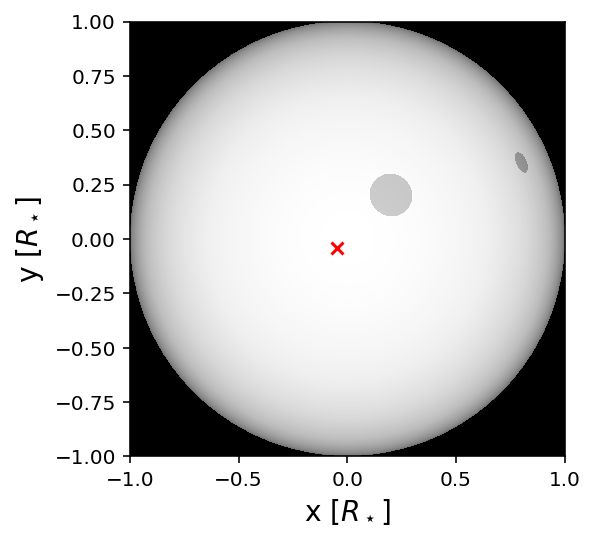

In [17]:
s = Star()

spot_list = [Spot(x=0.2, y=0.20, r=0.10),
             Spot(x=0.8, y=0.35, r=0.05)]

s.spots.extend(spot_list)

ax = s.plot(col_exaggerate=50)

For all dates in the MWO spot catalog, compute the solar photocenter. 

In [18]:
dates = sorted(list(set(spot_table['jd'])))
center_of_light = []

scale_up_umbra = 5

with ProgressBar(len(dates), ipython_widget=True) as bar:
    for date in dates:    
        sun = Star()
        spots_today = spot_table[spot_table['jd'] == date]

        for spot in spots_today:
            lon = spot['area_weighted_longitude_day_1']
            lat = spot['area_weighted_latitude_day_1']
            areas = spot['area_day_1']
            rspot_rstar = np.sqrt(1e-6 * 2 * (scale_up_umbra * areas))
            new_spot = Spot.from_latlon(lat, lon, rspot_rstar)
            sun.spots.append(new_spot)

        center_of_light.append(sun.center_of_light)
        bar.update()

center_of_light = np.array(center_of_light)
#     sun.plot()
#     plt.show()

../mrspoc/star.py:210: RuntimeWarning: invalid value encountered in sqrt
  spot_area = np.pi * spot.r**2 * np.sqrt(1 - (r_spot/self.r)**2)
../mrspoc/star.py:301: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1 - r**2)


In [19]:
#plt.scatter(center_of_light[:, 0], center_of_light[:, 1], marker='.', s=2, c=dates)

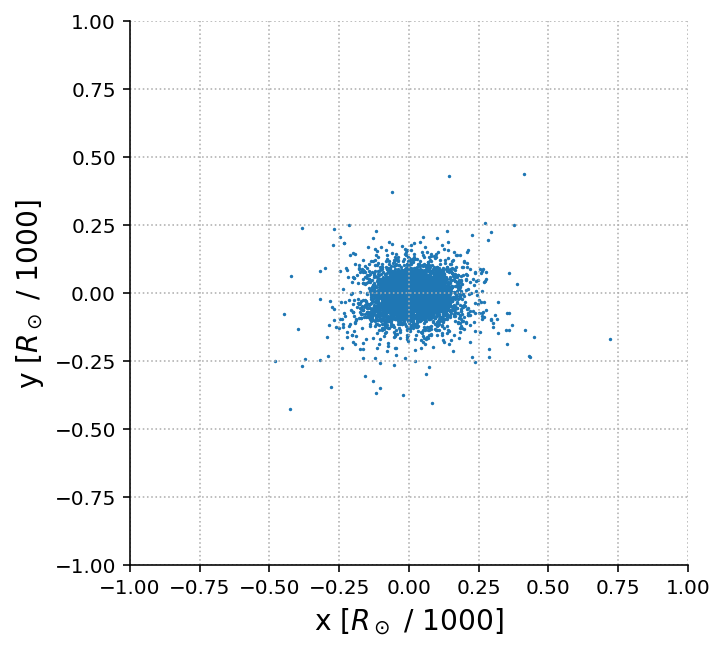

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(center_of_light[:, 0] * 1000, center_of_light[:, 1] * 1000, marker='.', s=2)
ax.set_xlabel('x [$R_\odot$ / 1000]', fontsize=14)
ax.set_ylabel('y [$R_\odot$ / 1000]', fontsize=14)
#ax.set(xlim=[-4, 4], ylim=[-4, 4])
ax.set(xlim=[-1, 1], ylim=[-1, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.grid(ls=':')
fig.savefig('plots/photocenter_motion.pdf', bbox_inches='tight')

What is the median absolute deviation of the solar photocenter over the entire MWO sample?

In [21]:
from astropy.stats import mad_std, median_absolute_deviation

mad = lambda x: mad_std(x)/1.4826

for mad in [lambda x: mad_std(x)/1.4826, median_absolute_deviation]:
    not_nan = ~np.any(np.isnan(center_of_light), axis=1)
    mad_x = mad(center_of_light[not_nan, 0])
    mad_y = mad(center_of_light[not_nan, 1])

    print("MAD x = {0}\nMAD y = {1}".format(mad_x, mad_y))

MAD x = 2.454140557309883e-05
MAD y = 1.532647247878843e-05
MAD x = 2.4541368850338623e-05
MAD y = 1.5326449544878965e-05


What was the maximum number of spots on the sun on a single day?

In [22]:
# nspots = np.array([len(spot_table[spot_table['jd'] == date]) for date in dates])
# print('max spots', np.max(nspots))
# plt.hist(nspots)

Compute the sizes 

In [23]:
spot_radii = np.sqrt(1e-6 * 10 * spot_table['area_day_1'])

Compute some basic stats on spot radii, number of spots on a typical day: 

In [25]:
#np.median(spot_radii), np.mean(nspots), np.median(nspots)

Compute the displacement vector of the solar photocenter from the true solar centroid at each time.

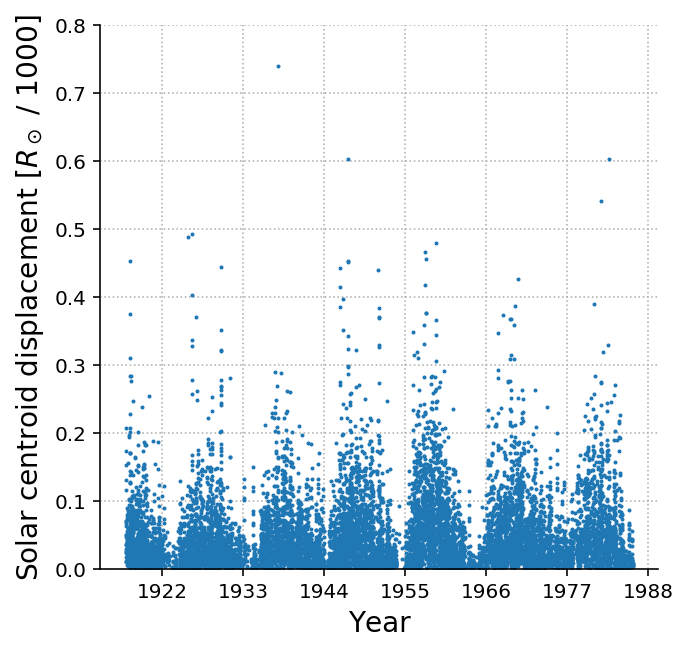

In [26]:
from astropy.time import Time

r_vector = np.sqrt(center_of_light[:, 0]**2 + center_of_light[:, 1]**2)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(Time(dates, format='jd').decimalyear, 1000 * r_vector, '.', markersize=2)

ax.set_xticks(np.arange(1922, 1990, 11))
#ax.set(ylim=[0.0, 0.003])
ax.set(ylim=[0.0, 0.8])
ax.set_xlabel('Year', fontsize=14) 
ax.set_ylabel('Solar centroid displacement [$R_\odot$ / 1000]', fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.grid(ls=':')
fig.savefig('plots/solar_centroid_displacement.pdf', bbox_inches='tight')

In [27]:
max_centroid_shift = np.nanmax(r_vector)
max_centroid_shift

0.001059820990671218

In [ ]:
from astropy.time import Time

date = dates[20]

s = Star()
spots_today = spot_table[spot_table['jd'] == date]

for spot in spots_today:
    lon = spot['area_weighted_longitude_day_1']
    lat = spot['area_weighted_latitude_day_1']
    areas = spot['area_day_1']
    rspot_rstar = np.sqrt(1e-6 * 2 * (scale_up_umbra * areas))
    new_spot = Spot.from_latlon(lat, lon, rspot_rstar)
    s.spots.append(new_spot)

print(Time(date, format='jd').iso)
ax = s.plot(col_exaggerate=100)
ax.axhline(0, ls=':', color='gray')
ax.axvline(0, ls=':', color='gray')
ax.set(xlabel='x [$R_\odot$]', ylabel='y [$R_\odot$]')
#fig.savefig('plots/example_sun.pdf', bbox_inches='tight')

In [ ]:
#date = dates[-6000]
date = dates[-4110]

fig, ax = plt.subplots()
s = Star()
spots_today = spot_table[spot_table['jd'] == date]

for spot in spots_today:
    lon = spot['area_weighted_longitude_day_1']
    lat = spot['area_weighted_latitude_day_1']
    areas = spot['area_day_1']
    rspot_rstar = np.sqrt(1e-6 * 2 * (scale_up_umbra * areas))
    new_spot = Spot.from_latlon(lat, lon, rspot_rstar)
    s.spots.append(new_spot)

print(Time(date, format='jd').iso)
ax = s.plot(col_exaggerate=100, n=8000, ax=ax)
ax.axhline(0, ls=':', color='gray')
ax.axvline(0, ls=':', color='gray')
ax.set(xlabel='x [$R_\odot$]', ylabel='y [$R_\odot$]')
fig.savefig('plots/example_sun.pdf', bbox_inches='tight', dpi=250)

In [ ]:
from astropy.constants import R_sun, M_sun, R_jup, M_jup, R_earth, M_earth, G
import astropy.units as u

a_jup = 5.2 * u.AU
a_earth = 1.0 * u.AU
p_jup = 11.8 * u.year
p_earth = 1 * u.year

# Solve for reflex motion radius

reflex_jup = ((a_jup * M_jup / M_sun)).decompose() / R_sun
reflex_earth = ((a_earth * M_earth / M_sun)).decompose() / R_sun

print(reflex_jup, reflex_earth)

In [ ]:
distance = 1 * u.pc
np.arctan(((reflex_jup*R_sun)/distance).decompose()).to(u.uarcsec)

In [ ]:
# Position jitter at D parsecs

from astropy.constants import R_sun
import astropy.units as u

distances = np.array([1, 5, 10])*u.pc
dates_plot = Time(dates, format='jd').plot_date

fig, ax = plt.subplots(1, len(distances), figsize=(14, 5))
for i, distance in enumerate(distances):
    angle = np.arctan(((r_vector*R_sun)/distance).decompose())

    print(np.std(angle.to(u.uarcsec).value), 'uas')
    
    earth_angle = np.arctan(((reflex_earth*R_sun)/distance).decompose())
    print('earth', earth_angle.to(u.uarcsec).value)
    ax[i].plot_date(dates_plot, angle.to(u.uarcsec), '.', alpha=0.2, 
                    label='Solar photocenter')
    ax[i].set_title('Distance = {0:d} pc'.format(int(distance.value)))
    ax[i].axhline(+earth_angle.to(u.uarcsec).value, ls='--', color='k', 
                  label=r"$\Delta \theta_{\oplus}$")

ax[0].legend(fontsize=12)
ax[0].set_ylabel('Spot-induced photocenter jitter [$\mu$arcec]', fontsize=14)
fig.savefig('plots/jitter.pdf', bbox_inches='tight', dpi=150)

On what day was the sunspot distribution most asymmetric? Plot a diagram of the sun on that day below. 

In [ ]:
Time(dates[np.argmax(r_vector)], format='jd').iso

In [ ]:
print(np.median(r_vector), np.max(r_vector))

date = dates[np.argmax(r_vector)]
fig, ax = plt.subplots()
s = Star()
spots_today = spot_table[spot_table['jd'] == date]

for spot in spots_today:
    lon = spot['area_weighted_longitude_day_1']
    lat = spot['area_weighted_latitude_day_1']
    areas = spot['area_day_1']
    rspot_rstar = np.sqrt(1e-6 * 2 * (scale_up_umbra * areas))
    new_spot = Spot.from_latlon(lat, lon, rspot_rstar)
    s.spots.append(new_spot)

print(Time(date, format='jd').iso)
ax = s.plot(col_exaggerate=10, ax=ax)
ax.axhline(0, ls=':', color='gray')
ax.axvline(0, ls=':', color='gray')
ax.set(xlabel='x [$R_\odot$]', ylabel='y [$R_\odot$]')
#fig.savefig('plots/example_sun.pdf', bbox_inches='tight')

*** 

## Gaia noise model

Simple Gaia noise model of Perryman et al. 2014:

$$ \sigma_{fov} = \sqrt{ \sigma_\eta^2/9 + \sigma_{att}^2 + \sigma_{cal}^2} $$

where $\sigma_{att} \approx \sigma_{cal} = 20 \mu$as, and

$$ \sigma_\eta = \sqrt{53000 z + 310 z^2} $$

for 

$$ z = 10^{0.4\left(\max[G, 12] - 15\right)}$$

Which stars have astrometric errors in DR1 smaller than the estimated jitter due to solar-like activity cycles?

In [56]:
#from mrspoc import get_table_ms
#table = get_table_ms()
#plt.hist(table['Teff'], log=True)

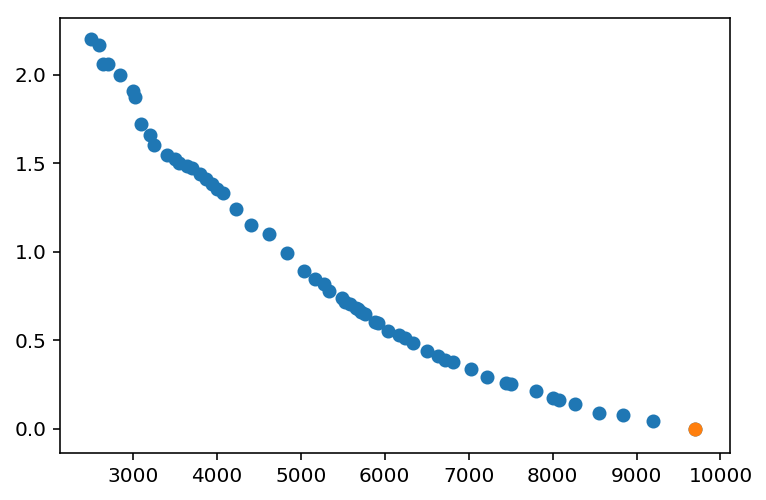

In [57]:
from astropy.table import Table
from astropy.io import ascii

# Source: http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt
mamajek = ascii.read('../data/spt_mamajek.txt', format='commented_header')

#p = np.polyfit((mamajek['Teff'] - 5000), mamajek['B-V'], 5)

#teff_range = np.linspace(2500, 10000, 100)
#bv_fit = np.polyval(p, (teff_range - 5000))

plt.scatter(mamajek['Teff'], mamajek['B-V'])

bv_to_teff = lambda bv: np.interp(bv, mamajek['B-V'], mamajek['Teff'])

plt.scatter(bv_to_teff(0), 0)

#plt.plot(teff_range, bv_fit)

In [12]:
# Compute the apparent angular jitter due to sunspots at the
# distances of nearby MS stars in the TGAS sample
distances = table['distance'].quantity
#R_star = bv_to_radius(table['B-V'].data.data)
R_star = table['R_star'].quantity
jitter_rstar =  np.nanstd(r_vector) * R_star
sigma_jitter = np.arctan((jitter_rstar/distances).decompose()).to(u.uarcsec)

# Estimate the single-measurement astrometric error for each star
# in the TGAS sample: 
sigma_gaia = table['sigma_fov']/np.sqrt(table['N_fov'])

NameError: name 'table' is not defined

In [11]:
jitter_rstar

NameError: name 'jitter_rstar' is not defined

Text(0.5,0,'Jitter [$\\mu$AU]')

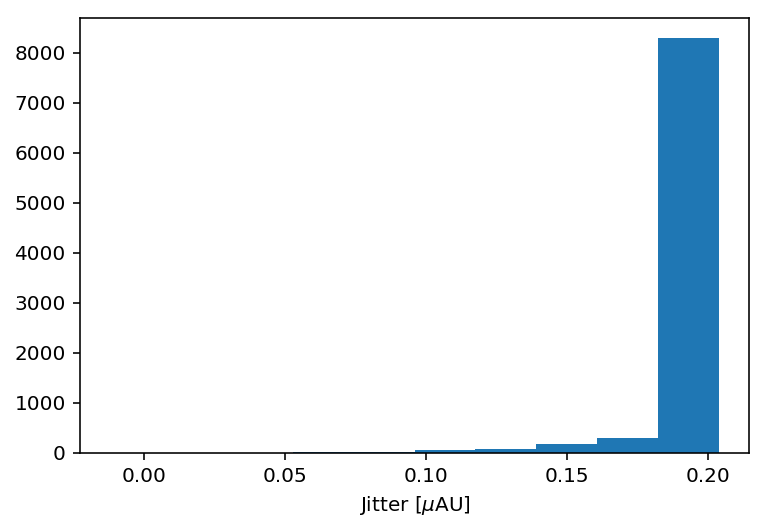

In [59]:
plt.hist(jitter_rstar.to(u.uAU).value)
plt.xlabel('Jitter [$\mu$AU]')

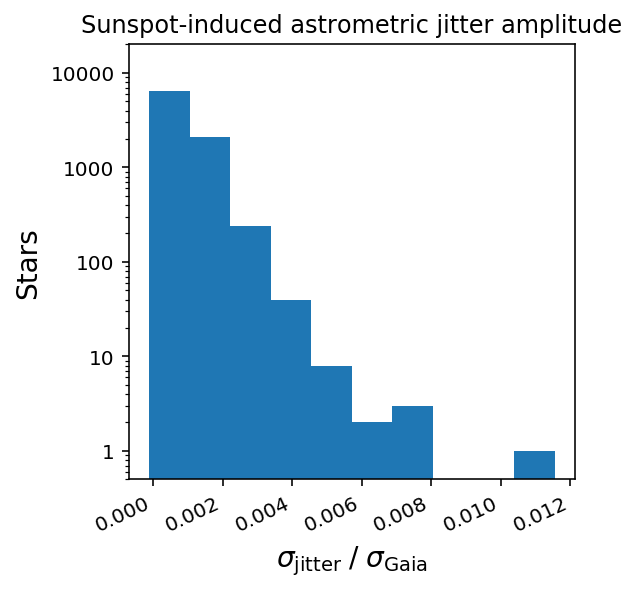

In [61]:
#plt.hist(jitter_amplitude, log=True);
fig, ax = plt.subplots(figsize=(4, 4))

np.save('sun_sn.npy', (sigma_jitter.value/sigma_gaia.data.data))

ax.hist(sigma_jitter/sigma_gaia, log=True, histtype='stepfilled')
ax.set_title('Sunspot-induced astrometric jitter amplitude')
ax.set_xlabel('$\sigma_{\mathrm{jitter}} \; / \; \sigma_{\mathrm{Gaia}}$', fontsize=14)
ax.set_ylabel('Stars', fontsize=14)
ax.set_ylim([0.5, 2e4])

y = [1, 10, 100, 1000, 1e4]
ax.set_yticks(y)
ax.set_yticklabels(["{0:g}".format(i) for i in y])

plt.setp(ax.get_xticklabels(), rotation=25, ha='right')

fig.savefig('plots/sunspot_jitter.pdf', bbox_inches='tight')

In [ ]:
len(sigma_jitter)

### Activity Cycle

In [ ]:
from astropy.table import Column

table.add_column(Column(data=sigma_jitter, name='sigma_jitter'))
table.add_column(Column(data=sigma_gaia, name='sigma_gaia'))
table.add_column(Column(data=(sigma_jitter/sigma_gaia).decompose(), name='snr'))

In [ ]:
snr_gtr20 = table[table['snr'] > 0.01]
print("N stars:", np.count_nonzero(snr_gtr20))

from astroquery.simbad import Simbad

sp_types = []
main_id = []
for hip_number in snr_gtr20['HIP']:
    customSimbad = Simbad()
    customSimbad.add_votable_fields('sptype')
    query = customSimbad.query_object("HIP {0}".format(hip_number))
    sp_types.append(query['SP_TYPE'][0])
    main_id.append(query['MAIN_ID'][0])

sptype_colname = 'Sp Type'
mainid_colname = 'main_id'

if not sptype_colname in snr_gtr20.colnames:
    snr_gtr20.add_column(Column(data=sp_types, name=sptype_colname))

if not mainid_colname in snr_gtr20.colnames:
    snr_gtr20.add_column(Column(data=main_id, name=mainid_colname))

In [ ]:
# from scipy.stats import anderson_ksamp, ks_2samp
# from astropy.utils.console import ProgressBar

# n_realizations = 1000

# anderson_matrix = np.zeros((len(snr_gtr20), n_realizations))
# ks_matrix = np.zeros((len(snr_gtr20), n_realizations))

# with ProgressBar(n_realizations, ipython_widget=True) as bar:
#     for i in range(n_realizations):
#         # Observe the star N_fov times at minimum
#         activity_minimum = [np.random.normal(loc=0, scale=sigma_fov, size=int(N_fov)) 
#                              for sigma_fov, N_fov in 
#                              zip(snr_gtr20['sigma_fov'].to(u.uarcsec).value, 
#                                  snr_gtr20['N_fov'])]

#         # Observe the star N_fov times at maximum
#         activity_maximum = [np.random.normal(loc=0, scale=np.sqrt(sigma_fov**2 + sigma_jitter**2), size=int(N_fov)) 
#                             for sigma_fov, sigma_jitter, N_fov in 
#                             zip(snr_gtr20['sigma_fov'].to(u.uarcsec).value, 
#                                 snr_gtr20['sigma_jitter'], 
#                                 snr_gtr20['N_fov'])]

#         # Compute the significance between position distributions activity minimum and maximum
#         anderson = np.array([anderson_ksamp([minimum, maximum]).significance_level 
#                              for minimum, maximum in zip(activity_minimum, activity_maximum)])
#         ks = np.array([ks_2samp(minimum, maximum).pvalue
#                        for minimum, maximum in zip(activity_minimum, activity_maximum)])

#         anderson_matrix[:, i] = anderson
#         ks_matrix[:, i] = ks
#         bar.update()